In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import sys
from copy import deepcopy

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_name = "ResNet18" # valid values: ResNet18, ResNet50

BATCH_SIZE = 128


Using device: cuda


In [30]:
'''
def create_fractional_list_for(n):
    if n == 0:
        return [] # Avoid division by zero
    
    result = []
    # Iterate from 0 up to and including n
    for i in range(n + 1):
        result.append(i / n)
    return result
n_value = 6
my_list = create_fractional_list_for(n_value)
print(f"List for n={n_value}: {my_list}")
'''

'\ndef create_fractional_list_for(n):\n    if n == 0:\n        return [] # Avoid division by zero\n    \n    result = []\n    # Iterate from 0 up to and including n\n    for i in range(n + 1):\n        result.append(i / n)\n    return result\nn_value = 6\nmy_list = create_fractional_list_for(n_value)\nprint(f"List for n={n_value}: {my_list}")\n'

In [31]:
# Load CIFAR-10
def load_cifar10(batch_size=128):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)
    return trainloader, testloader



In [32]:
# Load data
BATCH_SIZE = 128
print("\n..... Loading CIFAR-10 dataset...")
train_loader, test_loader = load_cifar10(BATCH_SIZE)
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")


..... Loading CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified
Training samples: 50000
Test samples: 10000


In [33]:
def evaluate_model(model, test_loader, criterion, mode=None,c=None):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Evaluating'):
            data, target = data.to(device), target.to(device)
            output = model(data, mode=mode,c=c)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    
    return test_loss, test_acc

In [34]:
def load_model(model_path, model_type='LeNet', device=None):

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    print(f"Loading {model_type} model from {model_path}...")
    
    # Initialize the model architecture
    if model_name == 'ResNet18':
        model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10)
    elif model_name == 'ResNet50':
        model = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=10)
    else:
        raise ValueError(f"Unknown model type: {model_type}. Use 'ResNet18' or 'ResNet50'")
    
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    
    # Load model weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()  # Set to evaluation mode
    
    print(f"✓ Model loaded successfully!")
    print(f"  - Trained for {checkpoint['epoch']} epochs")
    print(f"  - Test (Baseline) Accuracy: {checkpoint['test_acc']:.2f}%")
    print(f"  - Test Loss: {checkpoint['test_loss']:.4f}")
    
    # checkpoint: Dictionary containing training history and metrics
    return model, checkpoint

In [35]:
def load_test_model(model_path, model_type='LeNet', mode=None,c=None):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load the model
    model, checkpoint = load_model(model_path, model_type, device)
    
    # Load test data
    #_, test_loader = load_mnist(batch_size=128)
    
    # Evaluate the loaded model
    criterion = nn.CrossEntropyLoss()
    ver_loss, ver_acc = evaluate_model(model, test_loader, criterion, mode,c)
    
    print(f"\nVerification Test:")
    print(f"  Verification Loss: {ver_loss:.4f}")
    print(f"  Verification Accuracy: {ver_acc:.2f}%")
    
    # Access training history if needed
    if 'history' in checkpoint:
        history = checkpoint['history']
        print(f"\nTraining History Available:")
        print(f"  - Number of epochs: {len(history['train_loss'])}")
        print(f"  - Best train accuracy: {max(history['train_acc']):.2f}%")
        print(f"  - Best test accuracy: {max(history['test_acc']):.2f}%")
    
    return model, checkpoint

In [36]:
def verify_model(model, mode=None,c=None, verbose=False):
  
    # Evaluate the loaded model
    criterion = nn.CrossEntropyLoss()
    ver_loss, ver_acc = evaluate_model(model, test_loader, criterion, mode,c)
    
    print(f"\nVerification Test:")
    print(f"  Verification Loss: {ver_loss:.4f}")
    print(f"  Verification Accuracy: {ver_acc:.2f}%")
    
    '''
    # Access training history if needed
    if verbose:
        if 'history' in checkpoint:
            history = checkpoint['history']
            print(f"\nTraining History Available:")
            print(f"  - Number of epochs: {len(history['train_loss'])}")
            print(f"  - Best train accuracy: {max(history['train_acc']):.2f}%")
            print(f"  - Best test accuracy: {max(history['test_acc']):.2f}%")
    '''
    
    return ver_acc, ver_loss

In [37]:
def line_box_intersection(line_start, line_end, box_min, box_max):
    """
    Finds the intersection points of a line segment and an axis-aligned bounding box (AABB).

    Args:
        line_start (np.array): The start point of the line (e.g., np.array([x, y, z])).
        line_end (np.array): The end point of the line (e.g., np.array([x, y, z])).
        box_min (np.array): The minimum corner of the box (e.g., np.array([xmin, ymin, zmin])).
        box_max (np.array): The maximum corner of the box (e.g., np.array([xmax, ymax, zmax])).

    Returns:
        list: A list of intersection points (up to two points).
    """
    #thanks Google's AI
    
    line_dir = line_end - line_start
    
    # Pre-calculate inverse direction components to replace division with multiplication (faster)
    # Handle cases where a component is zero
    inv_dir = np.array([1/line_dir[i] if line_dir[i] != 0 else np.inf for i in range(len(line_dir))])

    t_min = -np.inf
    t_max = np.inf
    
    intersection_points = []

    for i in range(len(line_start)): # Iterate over x, y, z dimensions
        t1 = (box_min[i] - line_start[i]) * inv_dir[i]
        t2 = (box_max[i] - line_start[i]) * inv_dir[i]

        # Ensure t1 is the smaller intersection parameter
        if t1 > t2:
            t1, t2 = t2, t1

        # Update the overall t_min and t_max for the intersection interval
        t_min = max(t_min, t1)
        t_max = min(t_max, t2)

        # If t_min becomes greater than t_max, the line does not intersect the box
        if t_min > t_max:
            return []
    
    # The line intersects the box. The intersection occurs between t_min and t_max.
    # The actual points of entry and exit within the original line segment range [0, 1] are determined here.

    # Clamp t_min and t_max to the line segment range [0, 1] if you're working with a segment
    # If using an infinite line, skip this clamping step.
    t_start = max(0, t_min)
    t_end = min(1, t_max)

    if t_start <= t_end:
        # Calculate intersection points
        if t_start >= 0 and t_start <= 1:
            points = line_start + t_start * line_dir
            intersection_points.append(points)
        if t_end >= 0 and t_end <= 1 and t_end != t_start: # Avoid adding the same point twice
            points = line_start + t_end * line_dir
            intersection_points.append(points)   
    return intersection_points

def split_line_nd(start_point, end_point, num_points):
    """
    Generates num_points equally spaced along a line segment between 
    start_point and end_point in N dimensions.

    Args:
        start_point (iterable): The starting point (e.g., [x1, y1, z1])
        end_point (iterable): The ending point (e.g., [x2, y2, z2])
        num_points (int): The total number of points to generate (must be >= 2).

    Returns:
        np.ndarray: An array of shape (num_points, N) containing the points.
    """
    #thanks Google's AI
    if num_points < 2:
        return np.array([start_point, end_point])

    # Convert to numpy arrays for easier calculation
    p1 = np.array(start_point)
    p2 = np.array(end_point)
    
    # Generate the interpolation factors (0 to 1)
    # The number of steps is num_points - 1
    t = np.linspace(0, 1, num_points)

    # Linear interpolation formula: P(t) = P1 + t * (P2 - P1)
    # The result will be an array of points
    points = p1 + t[:, np.newaxis] * (p2 - p1)
    
    return points

def getcpoints(x0,u,num_segments=5):
    x1=x0+u

    box_min = np.zeros_like(x0)
    box_max = np.ones_like(x0)
    intersection_points = line_box_intersection(x0, x1, box_min, box_max)
    if len(intersection_points) == 2:
        start,end = intersection_points
        result_points = split_line_nd(start, end, num_segments)
        return(result_points)
    else: 
        print("intersection_points NOT found")
        return(None)

In [38]:
# ======== Basic Residual Block (used in ResNet-18/34) ======== #
class BasicBlock(nn.Module):
    expansion = 1  # output channels = in_channels * expansion

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)
        return out


# ======== Bottleneck Block (used in ResNet-50/101/152) ======== #
class Bottleneck(nn.Module):
    expansion = 4  # output channels = out_channels * 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)
        return out


# ======== ResNet Architecture ======== #
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super().__init__()
        self.in_channels = 64

        # Initial convolution + maxpool
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual layers
        self.layer1 = self._make_layer(block, 64,  layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Classification head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # Weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x, mode=None,pp=False,c=(0,0,0,0)):
    #def forward(self, x, mode=None):
        if c==None:
            c=(0,0,0,0)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        if mode=="compress":
            x=compress(x,c[0])
        x = self.layer1(x)
        
        if mode=="compress":
            x=compress(x,c[1])
        x = self.layer2(x)
        
        if mode=="compress":
            x=compress(x,c[2])
        x = self.layer3(x)
        
        if mode=="compress":
            x=compress(x,c[3])
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    

# ======== Factory functions ======== #
def ResNet18(num_classes=1000):
    """Constructs a ResNet-18 model."""
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)


def ResNet50(num_classes=1000):
    """Constructs a ResNet-50 model."""
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes)



In [39]:
def compress(X,c=1):
    c=1-c
    if c==1:
        return X
    dout = X.shape[1]
    
    # Calculate L1 norm for each output channel
    if len(X.shape)==2:
        Xvalues = torch.abs(X)
    elif len(X.shape)==4:
        Xvalues = torch.sum(torch.abs(X), dim=(2, 3))

    #print(Xvalues.shape)
    
    # Calculate how many channels to prune
    k = int(dout * c)

    x, i = torch.topk(Xvalues, k, dim=1)
    mask = torch.zeros_like(Xvalues,dtype=torch.int)
    src = torch.ones_like(i,dtype=torch.int)
    mask.scatter_(1, i, src)
    #print(Xvalues,x,i)
    #print(mask)
    if len(X.shape)==2:
        return mask*X
    else:
        #print(mask.shape,X.shape)
        #print(mask)
        mask=mask.unsqueeze(2)
        mask=mask.unsqueeze(3)
        mask=mask.repeat((1,1,X.shape[2],X.shape[3]))
        return mask*X

In [40]:
# Load the model
model_filename = f'{model_name}_cifar10.pth'
print("\n------ Loading model ..... \n")
model, checkpoint = load_model(model_filename, model_name, device)


------ Loading model ..... 

Loading ResNet18 model from ResNet18_cifar10.pth...


/tmp/ipykernel_4154780/910308833.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


✓ Model loaded successfully!
  - Trained for 10 epochs
  - Test (Baseline) Accuracy: 77.17%
  - Test Loss: 1.1054


In [41]:
# Load & Verify model
'''
model_filename = f'{model_name}_mnist.pth'
print("\n------ Loading & Verifying model .......\n")
lenet_model, lenet_checkpoint = load_test_model(model_filename, model_name, mode="compress",c=(0.5,0.3,0.1,0.1))
'''

'\nmodel_filename = f\'{model_name}_mnist.pth\'\nprint("\n------ Loading & Verifying model .......\n")\nlenet_model, lenet_checkpoint = load_test_model(model_filename, model_name, mode="compress",c=(0.5,0.3,0.1,0.1))\n'

In [42]:
# Verify the model
'''
print("\n------ Verifying model ..... \n")
ver_acc, ver_loss = verify_model(model, mode="compress",c=(0.5,0.3,0.1,0.1))
'''

'\nprint("\n------ Verifying model ..... \n")\nver_acc, ver_loss = verify_model(model, mode="compress",c=(0.5,0.3,0.1,0.1))\n'

In [43]:
def run_experiments(model, compressions, max_segments):

    results = {}
    compresion_id = 0
    for compression in compressions:
        print(f"\n-------- Analyzing {compression}:")
        
        line_start_2d = np.array(compression[0])
        line_dir = np.array(compression[1])
        cpoints = getcpoints(line_start_2d,line_dir,max_segments)
        if cpoints is None:
            print(".... skipping ....")
            continue
        print("\n ---- CPOINTS: -----\n")
        print(cpoints)
        print("-----------------------\n")
        accuracies = []
        for ci in cpoints:
            ver_acc, ver_loss = verify_model(model, mode="compress",c=ci.tolist())
            accuracies.append(ver_acc)
            print(f"\n------  C point {ci} : {ver_acc:.2f}%\n")
        
        results[compresion_id] = accuracies
        compresion_id = compresion_id + 1
    return results

In [44]:
# Plotting
def plot_experiment_results(checkpoint, results, model_name, max_segments):
    #segments = [f"{i}/{max_segments}" for i in range(max_segments + 1)]
    segments = list(range(1, max_segments+1))

    baseline_acc = checkpoint['test_acc']

    plt.figure(figsize=(10, 6))
    for compression_id, accuracies in results.items():
        # !!!! TEO
        # !!!! Label = current compression and not the 1st and last cpoints of current compression
        plt.plot(segments, accuracies, marker='o', label=compressions[compression_id], linewidth=2)

    plt.xlabel('Segments', fontsize=12)
    plt.ylabel('Verification Accuracy (%)', fontsize=12)
    plt.title(f'{model_name} - Accuracy vs Compression by segment', fontsize=14)
    
    plt.grid(True, alpha=0.3)
    plt.axhline(y=baseline_acc, color='r', linestyle='--', alpha=0.5, label='Baseline')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{model_name.replace(" ", "_")}_compression.png', dpi=300)
    plt.show()

In [45]:

max_segments = 8

/tmp/ipykernel_4154780/999807503.py:28: RuntimeWarning: invalid value encountered in scalar multiply
  t1 = (box_min[i] - line_start[i]) * inv_dir[i]



-------- Analyzing [[0, 0, 0, 0], [1, 0, 0, 0]]:

 ---- CPOINTS: -----

[[0.         0.         0.         0.        ]
 [0.14285714 0.         0.         0.        ]
 [0.28571429 0.         0.         0.        ]
 [0.42857143 0.         0.         0.        ]
 [0.57142857 0.         0.         0.        ]
 [0.71428571 0.         0.         0.        ]
 [0.85714286 0.         0.         0.        ]
 [1.         0.         0.         0.        ]]
-----------------------



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.77it/s]



Verification Test:
  Verification Loss: 1.1054
  Verification Accuracy: 77.17%

------  C point [0. 0. 0. 0.] : 77.17%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.87it/s]



Verification Test:
  Verification Loss: 1.1992
  Verification Accuracy: 75.77%

------  C point [0.14285714 0.         0.         0.        ] : 75.77%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.57it/s]



Verification Test:
  Verification Loss: 1.4044
  Verification Accuracy: 71.56%

------  C point [0.28571429 0.         0.         0.        ] : 71.56%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.91it/s]



Verification Test:
  Verification Loss: 1.9022
  Verification Accuracy: 63.88%

------  C point [0.42857143 0.         0.         0.        ] : 63.88%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.91it/s]



Verification Test:
  Verification Loss: 2.8417
  Verification Accuracy: 52.59%

------  C point [0.57142857 0.         0.         0.        ] : 52.59%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.39it/s]



Verification Test:
  Verification Loss: 4.0388
  Verification Accuracy: 40.24%

------  C point [0.71428571 0.         0.         0.        ] : 40.24%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.97it/s]



Verification Test:
  Verification Loss: 4.9788
  Verification Accuracy: 31.84%

------  C point [0.85714286 0.         0.         0.        ] : 31.84%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.76it/s]



Verification Test:
  Verification Loss: 8.2939
  Verification Accuracy: 10.00%

------  C point [1. 0. 0. 0.] : 10.00%


-------- Analyzing [[0, 0, 0, 0], [1, 1, 1, 1]]:

 ---- CPOINTS: -----

[[0.         0.         0.         0.        ]
 [0.14285714 0.14285714 0.14285714 0.14285714]
 [0.28571429 0.28571429 0.28571429 0.28571429]
 [0.42857143 0.42857143 0.42857143 0.42857143]
 [0.57142857 0.57142857 0.57142857 0.57142857]
 [0.71428571 0.71428571 0.71428571 0.71428571]
 [0.85714286 0.85714286 0.85714286 0.85714286]
 [1.         1.         1.         1.        ]]
-----------------------



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  7.01it/s]



Verification Test:
  Verification Loss: 1.1054
  Verification Accuracy: 77.17%

------  C point [0. 0. 0. 0.] : 77.17%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.74it/s]



Verification Test:
  Verification Loss: 1.4336
  Verification Accuracy: 73.37%

------  C point [0.14285714 0.14285714 0.14285714 0.14285714] : 73.37%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.66it/s]



Verification Test:
  Verification Loss: 2.2005
  Verification Accuracy: 63.73%

------  C point [0.28571429 0.28571429 0.28571429 0.28571429] : 63.73%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.79it/s]



Verification Test:
  Verification Loss: 3.7720
  Verification Accuracy: 48.39%

------  C point [0.42857143 0.42857143 0.42857143 0.42857143] : 48.39%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.77it/s]



Verification Test:
  Verification Loss: 5.7792
  Verification Accuracy: 33.82%

------  C point [0.57142857 0.57142857 0.57142857 0.57142857] : 33.82%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.84it/s]



Verification Test:
  Verification Loss: 7.2026
  Verification Accuracy: 23.27%

------  C point [0.71428571 0.71428571 0.71428571 0.71428571] : 23.27%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.86it/s]



Verification Test:
  Verification Loss: 10.4314
  Verification Accuracy: 10.83%

------  C point [0.85714286 0.85714286 0.85714286 0.85714286] : 10.83%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.78it/s]



Verification Test:
  Verification Loss: 12.0594
  Verification Accuracy: 10.00%

------  C point [1. 1. 1. 1.] : 10.00%


-------- Analyzing [[0, 0, 0, 0], [0, 1, 1, 0]]:

 ---- CPOINTS: -----

[[0.         0.         0.         0.        ]
 [0.         0.14285714 0.14285714 0.        ]
 [0.         0.28571429 0.28571429 0.        ]
 [0.         0.42857143 0.42857143 0.        ]
 [0.         0.57142857 0.57142857 0.        ]
 [0.         0.71428571 0.71428571 0.        ]
 [0.         0.85714286 0.85714286 0.        ]
 [0.         1.         1.         0.        ]]
-----------------------



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.45it/s]



Verification Test:
  Verification Loss: 1.1054
  Verification Accuracy: 77.17%

------  C point [0. 0. 0. 0.] : 77.17%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.90it/s]



Verification Test:
  Verification Loss: 1.2209
  Verification Accuracy: 75.69%

------  C point [0.         0.14285714 0.14285714 0.        ] : 75.69%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.97it/s]



Verification Test:
  Verification Loss: 1.4917
  Verification Accuracy: 71.46%

------  C point [0.         0.28571429 0.28571429 0.        ] : 71.46%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.10it/s]



Verification Test:
  Verification Loss: 1.9354
  Verification Accuracy: 64.97%

------  C point [0.         0.42857143 0.42857143 0.        ] : 64.97%



Evaluating: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]



Verification Test:
  Verification Loss: 2.5655
  Verification Accuracy: 55.32%

------  C point [0.         0.57142857 0.57142857 0.        ] : 55.32%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.50it/s]



Verification Test:
  Verification Loss: 3.5072
  Verification Accuracy: 42.60%

------  C point [0.         0.71428571 0.71428571 0.        ] : 42.60%



Evaluating: 100%|██████████| 79/79 [00:13<00:00,  5.93it/s]



Verification Test:
  Verification Loss: 4.4098
  Verification Accuracy: 26.92%

------  C point [0.         0.85714286 0.85714286 0.        ] : 26.92%



Evaluating: 100%|██████████| 79/79 [00:17<00:00,  4.41it/s]



Verification Test:
  Verification Loss: 3.6386
  Verification Accuracy: 10.00%

------  C point [0. 1. 1. 0.] : 10.00%


-------- Analyzing [[0, 0, 0, 0], [0.25, 0.5, 0.75, 1]]:

 ---- CPOINTS: -----

[[0.         0.         0.         0.        ]
 [0.03571429 0.07142857 0.10714286 0.14285714]
 [0.07142857 0.14285714 0.21428571 0.28571429]
 [0.10714286 0.21428571 0.32142857 0.42857143]
 [0.14285714 0.28571429 0.42857143 0.57142857]
 [0.17857143 0.35714286 0.53571429 0.71428571]
 [0.21428571 0.42857143 0.64285714 0.85714286]
 [0.25       0.5        0.75       1.        ]]
-----------------------



Evaluating: 100%|██████████| 79/79 [00:19<00:00,  4.06it/s]



Verification Test:
  Verification Loss: 1.1054
  Verification Accuracy: 77.17%

------  C point [0. 0. 0. 0.] : 77.17%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.64it/s]



Verification Test:
  Verification Loss: 1.2451
  Verification Accuracy: 76.24%

------  C point [0.03571429 0.07142857 0.10714286 0.14285714] : 76.24%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.44it/s]



Verification Test:
  Verification Loss: 1.5122
  Verification Accuracy: 73.66%

------  C point [0.07142857 0.14285714 0.21428571 0.28571429] : 73.66%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.64it/s]



Verification Test:
  Verification Loss: 1.8454
  Verification Accuracy: 69.63%

------  C point [0.10714286 0.21428571 0.32142857 0.42857143] : 69.63%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.72it/s]



Verification Test:
  Verification Loss: 2.4274
  Verification Accuracy: 62.17%

------  C point [0.14285714 0.28571429 0.42857143 0.57142857] : 62.17%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.78it/s]



Verification Test:
  Verification Loss: 3.2714
  Verification Accuracy: 52.32%

------  C point [0.17857143 0.35714286 0.53571429 0.71428571] : 52.32%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.80it/s]



Verification Test:
  Verification Loss: 5.1242
  Verification Accuracy: 31.52%

------  C point [0.21428571 0.42857143 0.64285714 0.85714286] : 31.52%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.79it/s]



Verification Test:
  Verification Loss: 12.0594
  Verification Accuracy: 10.00%

------  C point [0.25 0.5  0.75 1.  ] : 10.00%


-------- Analyzing [[0, 0, 0, 0], [0, 0.3, 1, 1]]:

 ---- CPOINTS: -----

[[0.         0.         0.         0.        ]
 [0.         0.04285714 0.14285714 0.14285714]
 [0.         0.08571429 0.28571429 0.28571429]
 [0.         0.12857143 0.42857143 0.42857143]
 [0.         0.17142857 0.57142857 0.57142857]
 [0.         0.21428571 0.71428571 0.71428571]
 [0.         0.25714286 0.85714286 0.85714286]
 [0.         0.3        1.         1.        ]]
-----------------------



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.61it/s]



Verification Test:
  Verification Loss: 1.1054
  Verification Accuracy: 77.17%

------  C point [0. 0. 0. 0.] : 77.17%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.82it/s]



Verification Test:
  Verification Loss: 1.2212
  Verification Accuracy: 76.71%

------  C point [0.         0.04285714 0.14285714 0.14285714] : 76.71%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.85it/s]



Verification Test:
  Verification Loss: 1.4162
  Verification Accuracy: 74.71%

------  C point [0.         0.08571429 0.28571429 0.28571429] : 74.71%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.85it/s]



Verification Test:
  Verification Loss: 1.7102
  Verification Accuracy: 71.25%

------  C point [0.         0.12857143 0.42857143 0.42857143] : 71.25%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  7.02it/s]



Verification Test:
  Verification Loss: 2.1901
  Verification Accuracy: 64.37%

------  C point [0.         0.17142857 0.57142857 0.57142857] : 64.37%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  7.02it/s]



Verification Test:
  Verification Loss: 3.1754
  Verification Accuracy: 50.78%

------  C point [0.         0.21428571 0.71428571 0.71428571] : 50.78%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.66it/s]



Verification Test:
  Verification Loss: 6.4136
  Verification Accuracy: 19.74%

------  C point [0.         0.25714286 0.85714286 0.85714286] : 19.74%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.18it/s]



Verification Test:
  Verification Loss: 12.0594
  Verification Accuracy: 10.00%

------  C point [0.  0.3 1.  1. ] : 10.00%


-------- Analyzing [[0, 0, 0, 0], [0, 1, 0, 0]]:

 ---- CPOINTS: -----

[[0.         0.         0.         0.        ]
 [0.         0.14285714 0.         0.        ]
 [0.         0.28571429 0.         0.        ]
 [0.         0.42857143 0.         0.        ]
 [0.         0.57142857 0.         0.        ]
 [0.         0.71428571 0.         0.        ]
 [0.         0.85714286 0.         0.        ]
 [0.         1.         0.         0.        ]]
-----------------------



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.83it/s]



Verification Test:
  Verification Loss: 1.1054
  Verification Accuracy: 77.17%

------  C point [0. 0. 0. 0.] : 77.17%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.85it/s]



Verification Test:
  Verification Loss: 1.1945
  Verification Accuracy: 75.71%

------  C point [0.         0.14285714 0.         0.        ] : 75.71%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  7.00it/s]



Verification Test:
  Verification Loss: 1.3780
  Verification Accuracy: 73.40%

------  C point [0.         0.28571429 0.         0.        ] : 73.40%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.90it/s]



Verification Test:
  Verification Loss: 1.6787
  Verification Accuracy: 68.75%

------  C point [0.         0.42857143 0.         0.        ] : 68.75%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.93it/s]



Verification Test:
  Verification Loss: 2.1460
  Verification Accuracy: 61.54%

------  C point [0.         0.57142857 0.         0.        ] : 61.54%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.55it/s]



Verification Test:
  Verification Loss: 3.1025
  Verification Accuracy: 49.33%

------  C point [0.         0.71428571 0.         0.        ] : 49.33%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.99it/s]



Verification Test:
  Verification Loss: 4.7674
  Verification Accuracy: 31.82%

------  C point [0.         0.85714286 0.         0.        ] : 31.82%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.93it/s]



Verification Test:
  Verification Loss: 7.7235
  Verification Accuracy: 10.00%

------  C point [0. 1. 0. 0.] : 10.00%


-------- Analyzing [[0, 0, 0, 0], [0, 0, 1, 0]]:

 ---- CPOINTS: -----

[[0.         0.         0.         0.        ]
 [0.         0.         0.14285714 0.        ]
 [0.         0.         0.28571429 0.        ]
 [0.         0.         0.42857143 0.        ]
 [0.         0.         0.57142857 0.        ]
 [0.         0.         0.71428571 0.        ]
 [0.         0.         0.85714286 0.        ]
 [0.         0.         1.         0.        ]]
-----------------------



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.66it/s]



Verification Test:
  Verification Loss: 1.1054
  Verification Accuracy: 77.17%

------  C point [0. 0. 0. 0.] : 77.17%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.92it/s]



Verification Test:
  Verification Loss: 1.1156
  Verification Accuracy: 77.14%

------  C point [0.         0.         0.14285714 0.        ] : 77.14%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.67it/s]



Verification Test:
  Verification Loss: 1.1431
  Verification Accuracy: 76.55%

------  C point [0.         0.         0.28571429 0.        ] : 76.55%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.69it/s]



Verification Test:
  Verification Loss: 1.1982
  Verification Accuracy: 75.84%

------  C point [0.         0.         0.42857143 0.        ] : 75.84%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.48it/s]



Verification Test:
  Verification Loss: 1.2631
  Verification Accuracy: 74.17%

------  C point [0.         0.         0.57142857 0.        ] : 74.17%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.77it/s]



Verification Test:
  Verification Loss: 1.3714
  Verification Accuracy: 70.37%

------  C point [0.         0.         0.71428571 0.        ] : 70.37%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.96it/s]



Verification Test:
  Verification Loss: 1.6021
  Verification Accuracy: 62.07%

------  C point [0.         0.         0.85714286 0.        ] : 62.07%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.84it/s]



Verification Test:
  Verification Loss: 3.6386
  Verification Accuracy: 10.00%

------  C point [0. 0. 1. 0.] : 10.00%


-------- Analyzing [[0, 0, 0, 0], [0, 0, 0, 1]]:

 ---- CPOINTS: -----

[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.14285714]
 [0.         0.         0.         0.28571429]
 [0.         0.         0.         0.42857143]
 [0.         0.         0.         0.57142857]
 [0.         0.         0.         0.71428571]
 [0.         0.         0.         0.85714286]
 [0.         0.         0.         1.        ]]
-----------------------



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.30it/s]



Verification Test:
  Verification Loss: 1.1054
  Verification Accuracy: 77.17%

------  C point [0. 0. 0. 0.] : 77.17%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.19it/s]



Verification Test:
  Verification Loss: 1.1946
  Verification Accuracy: 76.79%

------  C point [0.         0.         0.         0.14285714] : 76.79%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.90it/s]



Verification Test:
  Verification Loss: 1.3080
  Verification Accuracy: 76.36%

------  C point [0.         0.         0.         0.28571429] : 76.36%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.75it/s]



Verification Test:
  Verification Loss: 1.4647
  Verification Accuracy: 75.08%

------  C point [0.         0.         0.         0.42857143] : 75.08%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.86it/s]



Verification Test:
  Verification Loss: 1.6920
  Verification Accuracy: 72.00%

------  C point [0.         0.         0.         0.57142857] : 72.00%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.47it/s]



Verification Test:
  Verification Loss: 2.1672
  Verification Accuracy: 65.89%

------  C point [0.         0.         0.         0.71428571] : 65.89%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.93it/s]



Verification Test:
  Verification Loss: 3.8256
  Verification Accuracy: 43.91%

------  C point [0.         0.         0.         0.85714286] : 43.91%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.88it/s]



Verification Test:
  Verification Loss: 12.0594
  Verification Accuracy: 10.00%

------  C point [0. 0. 0. 1.] : 10.00%


-------- Analyzing [[0, 0, 0, 0], [0, 0.25, 0.25, 0.25]]:

 ---- CPOINTS: -----

[[0.         0.         0.         0.        ]
 [0.         0.03571429 0.03571429 0.03571429]
 [0.         0.07142857 0.07142857 0.07142857]
 [0.         0.10714286 0.10714286 0.10714286]
 [0.         0.14285714 0.14285714 0.14285714]
 [0.         0.17857143 0.17857143 0.17857143]
 [0.         0.21428571 0.21428571 0.21428571]
 [0.         0.25       0.25       0.25      ]]
-----------------------



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.92it/s]



Verification Test:
  Verification Loss: 1.1054
  Verification Accuracy: 77.17%

------  C point [0. 0. 0. 0.] : 77.17%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.70it/s]



Verification Test:
  Verification Loss: 1.1428
  Verification Accuracy: 76.99%

------  C point [0.         0.03571429 0.03571429 0.03571429] : 76.99%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.46it/s]



Verification Test:
  Verification Loss: 1.1791
  Verification Accuracy: 76.60%

------  C point [0.         0.07142857 0.07142857 0.07142857] : 76.60%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.53it/s]



Verification Test:
  Verification Loss: 1.2335
  Verification Accuracy: 76.21%

------  C point [0.         0.10714286 0.10714286 0.10714286] : 76.21%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.95it/s]



Verification Test:
  Verification Loss: 1.3182
  Verification Accuracy: 75.35%

------  C point [0.         0.14285714 0.14285714 0.14285714] : 75.35%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.79it/s]



Verification Test:
  Verification Loss: 1.3889
  Verification Accuracy: 74.61%

------  C point [0.         0.17857143 0.17857143 0.17857143] : 74.61%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.79it/s]



Verification Test:
  Verification Loss: 1.4708
  Verification Accuracy: 73.83%

------  C point [0.         0.21428571 0.21428571 0.21428571] : 73.83%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.60it/s]



Verification Test:
  Verification Loss: 1.5551
  Verification Accuracy: 72.77%

------  C point [0.   0.25 0.25 0.25] : 72.77%


-------- Analyzing [[0, 0, 0, 0], [0, 0.5, 0.5, 0.5]]:

 ---- CPOINTS: -----

[[0.         0.         0.         0.        ]
 [0.         0.07142857 0.07142857 0.07142857]
 [0.         0.14285714 0.14285714 0.14285714]
 [0.         0.21428571 0.21428571 0.21428571]
 [0.         0.28571429 0.28571429 0.28571429]
 [0.         0.35714286 0.35714286 0.35714286]
 [0.         0.42857143 0.42857143 0.42857143]
 [0.         0.5        0.5        0.5       ]]
-----------------------



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.95it/s]



Verification Test:
  Verification Loss: 1.1054
  Verification Accuracy: 77.17%

------  C point [0. 0. 0. 0.] : 77.17%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.95it/s]



Verification Test:
  Verification Loss: 1.1791
  Verification Accuracy: 76.60%

------  C point [0.         0.07142857 0.07142857 0.07142857] : 76.60%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.87it/s]



Verification Test:
  Verification Loss: 1.3182
  Verification Accuracy: 75.35%

------  C point [0.         0.14285714 0.14285714 0.14285714] : 75.35%



Evaluating: 100%|██████████| 79/79 [00:13<00:00,  6.03it/s]



Verification Test:
  Verification Loss: 1.4708
  Verification Accuracy: 73.83%

------  C point [0.         0.21428571 0.21428571 0.21428571] : 73.83%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.86it/s]



Verification Test:
  Verification Loss: 1.7287
  Verification Accuracy: 70.98%

------  C point [0.         0.28571429 0.28571429 0.28571429] : 70.98%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.42it/s]



Verification Test:
  Verification Loss: 2.0380
  Verification Accuracy: 67.09%

------  C point [0.         0.35714286 0.35714286 0.35714286] : 67.09%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.63it/s]



Verification Test:
  Verification Loss: 2.4757
  Verification Accuracy: 61.64%

------  C point [0.         0.42857143 0.42857143 0.42857143] : 61.64%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.36it/s]



Verification Test:
  Verification Loss: 2.9612
  Verification Accuracy: 56.59%

------  C point [0.  0.5 0.5 0.5] : 56.59%


-------- Analyzing [[0, 0, 0, 0], [0.5, 1, 0.75, 0.25]]:

 ---- CPOINTS: -----

[[0.         0.         0.         0.        ]
 [0.07142857 0.14285714 0.10714286 0.03571429]
 [0.14285714 0.28571429 0.21428571 0.07142857]
 [0.21428571 0.42857143 0.32142857 0.10714286]
 [0.28571429 0.57142857 0.42857143 0.14285714]
 [0.35714286 0.71428571 0.53571429 0.17857143]
 [0.42857143 0.85714286 0.64285714 0.21428571]
 [0.5        1.         0.75       0.25      ]]
-----------------------



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.77it/s]



Verification Test:
  Verification Loss: 1.1054
  Verification Accuracy: 77.17%

------  C point [0. 0. 0. 0.] : 77.17%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.69it/s]



Verification Test:
  Verification Loss: 1.2804
  Verification Accuracy: 74.76%

------  C point [0.07142857 0.14285714 0.10714286 0.03571429] : 74.76%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.55it/s]



Verification Test:
  Verification Loss: 1.6387
  Verification Accuracy: 69.88%

------  C point [0.14285714 0.28571429 0.21428571 0.07142857] : 69.88%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.90it/s]



Verification Test:
  Verification Loss: 2.2526
  Verification Accuracy: 62.20%

------  C point [0.21428571 0.42857143 0.32142857 0.10714286] : 62.20%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.79it/s]



Verification Test:
  Verification Loss: 3.2391
  Verification Accuracy: 50.68%

------  C point [0.28571429 0.57142857 0.42857143 0.14285714] : 50.68%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.75it/s]



Verification Test:
  Verification Loss: 4.6330
  Verification Accuracy: 39.33%

------  C point [0.35714286 0.71428571 0.53571429 0.17857143] : 39.33%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.92it/s]



Verification Test:
  Verification Loss: 6.5336
  Verification Accuracy: 25.05%

------  C point [0.42857143 0.85714286 0.64285714 0.21428571] : 25.05%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.58it/s]



Verification Test:
  Verification Loss: 6.5470
  Verification Accuracy: 10.00%

------  C point [0.5  1.   0.75 0.25] : 10.00%



/tmp/ipykernel_4154780/2600637697.py:12: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(segments, accuracies, marker='o', label=compressions[compression_id], linewidth=2)


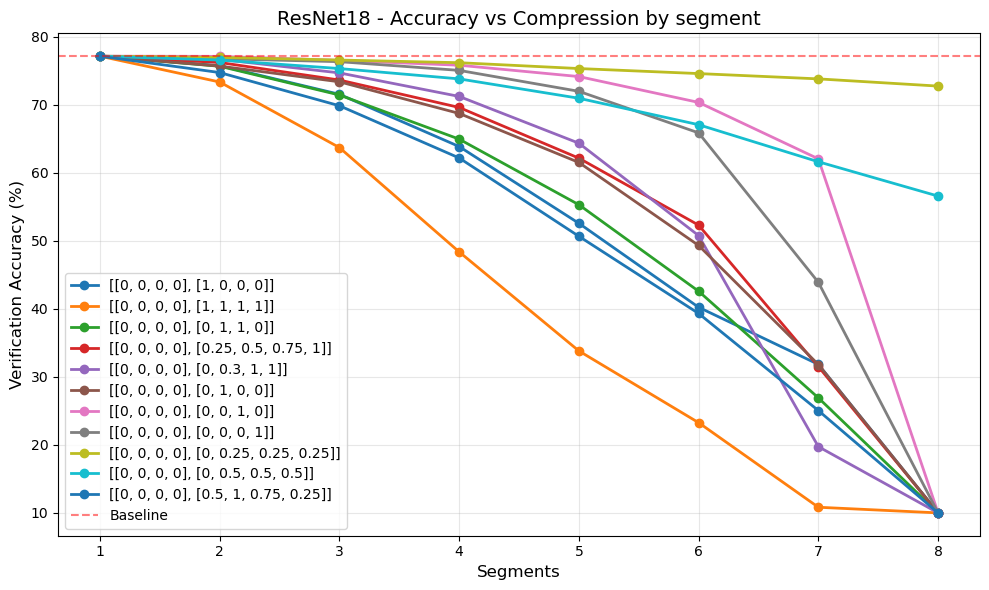

In [46]:
compressions = [[[0, 0, 0 ,0], [1, 0, 0, 0]],
                [[0, 0, 0 ,0], [1, 1, 1, 1]],
                [[0, 0, 0 ,0], [0, 1, 1, 0]],
                [[0, 0, 0 ,0], [0.25, 0.5, 0.75, 1]],
                [[0, 0, 0 ,0], [0, 0.3, 1, 1]],
                [[0, 0, 0 ,0], [0, 1, 0, 0]],
                [[0, 0, 0 ,0], [0, 0, 1, 0]],
                [[0, 0, 0 ,0], [0, 0, 0, 1]],
                [[0, 0, 0 ,0], [0, 0.25, 0.25, 0.25]],
                [[0, 0, 0 ,0], [0, 0.5, 0.5, 0.5]],
                [[0, 0, 0 ,0], [0.5, 1, 0.75, 0.25]]
]
results = run_experiments(model, compressions, max_segments)
plot_experiment_results(checkpoint, results, model_name, max_segments)

/tmp/ipykernel_4154780/999807503.py:28: RuntimeWarning: invalid value encountered in scalar multiply
  t1 = (box_min[i] - line_start[i]) * inv_dir[i]



-------- Analyzing [[0, 0, 0, 0], [0, 0.75, 0.75, 0.75]]:

 ---- CPOINTS: -----

[[0.         0.         0.         0.        ]
 [0.         0.10714286 0.10714286 0.10714286]
 [0.         0.21428571 0.21428571 0.21428571]
 [0.         0.32142857 0.32142857 0.32142857]
 [0.         0.42857143 0.42857143 0.42857143]
 [0.         0.53571429 0.53571429 0.53571429]
 [0.         0.64285714 0.64285714 0.64285714]
 [0.         0.75       0.75       0.75      ]]
-----------------------



Evaluating: 100%|██████████| 79/79 [00:15<00:00,  5.25it/s]



Verification Test:
  Verification Loss: 1.1054
  Verification Accuracy: 77.17%

------  C point [0. 0. 0. 0.] : 77.17%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.31it/s]



Verification Test:
  Verification Loss: 1.2335
  Verification Accuracy: 76.21%

------  C point [0.         0.10714286 0.10714286 0.10714286] : 76.21%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.73it/s]



Verification Test:
  Verification Loss: 1.4708
  Verification Accuracy: 73.83%

------  C point [0.         0.21428571 0.21428571 0.21428571] : 73.83%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.51it/s]



Verification Test:
  Verification Loss: 1.8927
  Verification Accuracy: 69.23%

------  C point [0.         0.32142857 0.32142857 0.32142857] : 69.23%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.73it/s]



Verification Test:
  Verification Loss: 2.4757
  Verification Accuracy: 61.64%

------  C point [0.         0.42857143 0.42857143 0.42857143] : 61.64%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.76it/s]



Verification Test:
  Verification Loss: 3.3531
  Verification Accuracy: 52.81%

------  C point [0.         0.53571429 0.53571429 0.53571429] : 52.81%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.12it/s]



Verification Test:
  Verification Loss: 4.7099
  Verification Accuracy: 39.65%

------  C point [0.         0.64285714 0.64285714 0.64285714] : 39.65%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.75it/s]



Verification Test:
  Verification Loss: 6.6155
  Verification Accuracy: 25.01%

------  C point [0.   0.75 0.75 0.75] : 25.01%


-------- Analyzing [[0, 0, 0, 0], [0, 0.25, 0.25, 0.5]]:

 ---- CPOINTS: -----

[[0.         0.         0.         0.        ]
 [0.         0.03571429 0.03571429 0.07142857]
 [0.         0.07142857 0.07142857 0.14285714]
 [0.         0.10714286 0.10714286 0.21428571]
 [0.         0.14285714 0.14285714 0.28571429]
 [0.         0.17857143 0.17857143 0.35714286]
 [0.         0.21428571 0.21428571 0.42857143]
 [0.         0.25       0.25       0.5       ]]
-----------------------



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.95it/s]



Verification Test:
  Verification Loss: 1.1054
  Verification Accuracy: 77.17%

------  C point [0. 0. 0. 0.] : 77.17%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.90it/s]



Verification Test:
  Verification Loss: 1.1644
  Verification Accuracy: 77.03%

------  C point [0.         0.03571429 0.03571429 0.07142857] : 77.03%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.74it/s]



Verification Test:
  Verification Loss: 1.2260
  Verification Accuracy: 76.38%

------  C point [0.         0.07142857 0.07142857 0.14285714] : 76.38%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.53it/s]



Verification Test:
  Verification Loss: 1.3054
  Verification Accuracy: 75.70%

------  C point [0.         0.10714286 0.10714286 0.21428571] : 75.70%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.59it/s]



Verification Test:
  Verification Loss: 1.4293
  Verification Accuracy: 74.98%

------  C point [0.         0.14285714 0.14285714 0.28571429] : 74.98%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.63it/s]



Verification Test:
  Verification Loss: 1.5506
  Verification Accuracy: 73.47%

------  C point [0.         0.17857143 0.17857143 0.35714286] : 73.47%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.87it/s]



Verification Test:
  Verification Loss: 1.6873
  Verification Accuracy: 71.98%

------  C point [0.         0.21428571 0.21428571 0.42857143] : 71.98%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.72it/s]



Verification Test:
  Verification Loss: 1.8423
  Verification Accuracy: 70.46%

------  C point [0.   0.25 0.25 0.5 ] : 70.46%


-------- Analyzing [[0, 0, 0, 0], [0, 0.25, 0.25, 0.75]]:

 ---- CPOINTS: -----

[[0.         0.         0.         0.        ]
 [0.         0.03571429 0.03571429 0.10714286]
 [0.         0.07142857 0.07142857 0.21428571]
 [0.         0.10714286 0.10714286 0.32142857]
 [0.         0.14285714 0.14285714 0.42857143]
 [0.         0.17857143 0.17857143 0.53571429]
 [0.         0.21428571 0.21428571 0.64285714]
 [0.         0.25       0.25       0.75      ]]
-----------------------



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  7.05it/s]



Verification Test:
  Verification Loss: 1.1054
  Verification Accuracy: 77.17%

------  C point [0. 0. 0. 0.] : 77.17%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.81it/s]



Verification Test:
  Verification Loss: 1.1871
  Verification Accuracy: 77.00%

------  C point [0.         0.03571429 0.03571429 0.10714286] : 77.00%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.39it/s]



Verification Test:
  Verification Loss: 1.2741
  Verification Accuracy: 76.27%

------  C point [0.         0.07142857 0.07142857 0.21428571] : 76.27%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.95it/s]



Verification Test:
  Verification Loss: 1.3973
  Verification Accuracy: 75.06%

------  C point [0.         0.10714286 0.10714286 0.32142857] : 75.06%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.89it/s]



Verification Test:
  Verification Loss: 1.5787
  Verification Accuracy: 73.28%

------  C point [0.         0.14285714 0.14285714 0.42857143] : 73.28%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.82it/s]



Verification Test:
  Verification Loss: 1.7810
  Verification Accuracy: 71.17%

------  C point [0.         0.17857143 0.17857143 0.53571429] : 71.17%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.96it/s]



Verification Test:
  Verification Loss: 2.0746
  Verification Accuracy: 67.60%

------  C point [0.         0.21428571 0.21428571 0.64285714] : 67.60%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.52it/s]



Verification Test:
  Verification Loss: 2.5787
  Verification Accuracy: 60.03%

------  C point [0.   0.25 0.25 0.75] : 60.03%


-------- Analyzing [[0, 0, 0, 0], [0.25, 1, 0, 0]]:

 ---- CPOINTS: -----

[[0.         0.         0.         0.        ]
 [0.03571429 0.14285714 0.         0.        ]
 [0.07142857 0.28571429 0.         0.        ]
 [0.10714286 0.42857143 0.         0.        ]
 [0.14285714 0.57142857 0.         0.        ]
 [0.17857143 0.71428571 0.         0.        ]
 [0.21428571 0.85714286 0.         0.        ]
 [0.25       1.         0.         0.        ]]
-----------------------



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  7.04it/s]



Verification Test:
  Verification Loss: 1.1054
  Verification Accuracy: 77.17%

------  C point [0. 0. 0. 0.] : 77.17%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.89it/s]



Verification Test:
  Verification Loss: 1.2096
  Verification Accuracy: 75.43%

------  C point [0.03571429 0.14285714 0.         0.        ] : 75.43%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.93it/s]



Verification Test:
  Verification Loss: 1.4273
  Verification Accuracy: 72.62%

------  C point [0.07142857 0.28571429 0.         0.        ] : 72.62%



Evaluating: 100%|██████████| 79/79 [00:13<00:00,  6.05it/s]



Verification Test:
  Verification Loss: 1.7632
  Verification Accuracy: 67.50%

------  C point [0.10714286 0.42857143 0.         0.        ] : 67.50%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.31it/s]



Verification Test:
  Verification Loss: 2.3368
  Verification Accuracy: 59.02%

------  C point [0.14285714 0.57142857 0.         0.        ] : 59.02%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.91it/s]



Verification Test:
  Verification Loss: 3.3686
  Verification Accuracy: 46.96%

------  C point [0.17857143 0.71428571 0.         0.        ] : 46.96%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.93it/s]



Verification Test:
  Verification Loss: 5.0276
  Verification Accuracy: 31.04%

------  C point [0.21428571 0.85714286 0.         0.        ] : 31.04%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.99it/s]



Verification Test:
  Verification Loss: 7.7235
  Verification Accuracy: 10.00%

------  C point [0.25 1.   0.   0.  ] : 10.00%


-------- Analyzing [[0, 0, 0, 0], [0.25, 0, 1, 0]]:

 ---- CPOINTS: -----

[[0.         0.         0.         0.        ]
 [0.03571429 0.         0.14285714 0.        ]
 [0.07142857 0.         0.28571429 0.        ]
 [0.10714286 0.         0.42857143 0.        ]
 [0.14285714 0.         0.57142857 0.        ]
 [0.17857143 0.         0.71428571 0.        ]
 [0.21428571 0.         0.85714286 0.        ]
 [0.25       0.         1.         0.        ]]
-----------------------



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  7.02it/s]



Verification Test:
  Verification Loss: 1.1054
  Verification Accuracy: 77.17%

------  C point [0. 0. 0. 0.] : 77.17%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.50it/s]



Verification Test:
  Verification Loss: 1.1280
  Verification Accuracy: 76.95%

------  C point [0.03571429 0.         0.14285714 0.        ] : 76.95%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.90it/s]



Verification Test:
  Verification Loss: 1.1904
  Verification Accuracy: 76.07%

------  C point [0.07142857 0.         0.28571429 0.        ] : 76.07%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.85it/s]



Verification Test:
  Verification Loss: 1.2713
  Verification Accuracy: 73.96%

------  C point [0.10714286 0.         0.42857143 0.        ] : 73.96%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.94it/s]



Verification Test:
  Verification Loss: 1.4034
  Verification Accuracy: 71.84%

------  C point [0.14285714 0.         0.57142857 0.        ] : 71.84%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.93it/s]



Verification Test:
  Verification Loss: 1.6032
  Verification Accuracy: 66.57%

------  C point [0.17857143 0.         0.71428571 0.        ] : 66.57%



Evaluating: 100%|██████████| 79/79 [00:13<00:00,  5.93it/s]



Verification Test:
  Verification Loss: 1.8847
  Verification Accuracy: 57.78%

------  C point [0.21428571 0.         0.85714286 0.        ] : 57.78%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.88it/s]



Verification Test:
  Verification Loss: 3.6386
  Verification Accuracy: 10.00%

------  C point [0.25 0.   1.   0.  ] : 10.00%


-------- Analyzing [[0, 0, 0, 0], [0.25, 0, 0, 1]]:

 ---- CPOINTS: -----

[[0.         0.         0.         0.        ]
 [0.03571429 0.         0.         0.14285714]
 [0.07142857 0.         0.         0.28571429]
 [0.10714286 0.         0.         0.42857143]
 [0.14285714 0.         0.         0.57142857]
 [0.17857143 0.         0.         0.71428571]
 [0.21428571 0.         0.         0.85714286]
 [0.25       0.         0.         1.        ]]
-----------------------



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.60it/s]



Verification Test:
  Verification Loss: 1.1054
  Verification Accuracy: 77.17%

------  C point [0. 0. 0. 0.] : 77.17%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.45it/s]



Verification Test:
  Verification Loss: 1.2071
  Verification Accuracy: 76.55%

------  C point [0.03571429 0.         0.         0.14285714] : 76.55%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.85it/s]



Verification Test:
  Verification Loss: 1.3455
  Verification Accuracy: 75.79%

------  C point [0.07142857 0.         0.         0.28571429] : 75.79%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.27it/s]



Verification Test:
  Verification Loss: 1.5265
  Verification Accuracy: 74.07%

------  C point [0.10714286 0.         0.         0.42857143] : 74.07%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.77it/s]



Verification Test:
  Verification Loss: 1.8019
  Verification Accuracy: 70.90%

------  C point [0.14285714 0.         0.         0.57142857] : 70.90%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.79it/s]



Verification Test:
  Verification Loss: 2.2758
  Verification Accuracy: 64.14%

------  C point [0.17857143 0.         0.         0.71428571] : 64.14%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.66it/s]



Verification Test:
  Verification Loss: 3.8811
  Verification Accuracy: 43.11%

------  C point [0.21428571 0.         0.         0.85714286] : 43.11%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.78it/s]



Verification Test:
  Verification Loss: 12.0594
  Verification Accuracy: 10.00%

------  C point [0.25 0.   0.   1.  ] : 10.00%


-------- Analyzing [[0, 0, 0, 0], [0.25, 0, 0, 0]]:

 ---- CPOINTS: -----

[[0.         0.         0.         0.        ]
 [0.03571429 0.         0.         0.        ]
 [0.07142857 0.         0.         0.        ]
 [0.10714286 0.         0.         0.        ]
 [0.14285714 0.         0.         0.        ]
 [0.17857143 0.         0.         0.        ]
 [0.21428571 0.         0.         0.        ]
 [0.25       0.         0.         0.        ]]
-----------------------



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.50it/s]



Verification Test:
  Verification Loss: 1.1054
  Verification Accuracy: 77.17%

------  C point [0. 0. 0. 0.] : 77.17%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.96it/s]



Verification Test:
  Verification Loss: 1.1174
  Verification Accuracy: 76.87%

------  C point [0.03571429 0.         0.         0.        ] : 76.87%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  7.06it/s]



Verification Test:
  Verification Loss: 1.1358
  Verification Accuracy: 76.65%

------  C point [0.07142857 0.         0.         0.        ] : 76.65%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.94it/s]



Verification Test:
  Verification Loss: 1.1636
  Verification Accuracy: 76.11%

------  C point [0.10714286 0.         0.         0.        ] : 76.11%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  7.04it/s]



Verification Test:
  Verification Loss: 1.1992
  Verification Accuracy: 75.77%

------  C point [0.14285714 0.         0.         0.        ] : 75.77%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.85it/s]



Verification Test:
  Verification Loss: 1.2198
  Verification Accuracy: 75.38%

------  C point [0.17857143 0.         0.         0.        ] : 75.38%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.70it/s]



Verification Test:
  Verification Loss: 1.2597
  Verification Accuracy: 74.77%

------  C point [0.21428571 0.         0.         0.        ] : 74.77%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  7.06it/s]



Verification Test:
  Verification Loss: 1.3064
  Verification Accuracy: 73.72%

------  C point [0.25 0.   0.   0.  ] : 73.72%


-------- Analyzing [[0, 0, 0, 0], [0.25, 0, 1, 1]]:

 ---- CPOINTS: -----

[[0.         0.         0.         0.        ]
 [0.03571429 0.         0.14285714 0.14285714]
 [0.07142857 0.         0.28571429 0.28571429]
 [0.10714286 0.         0.42857143 0.42857143]
 [0.14285714 0.         0.57142857 0.57142857]
 [0.17857143 0.         0.71428571 0.71428571]
 [0.21428571 0.         0.85714286 0.85714286]
 [0.25       0.         1.         1.        ]]
-----------------------



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  7.10it/s]



Verification Test:
  Verification Loss: 1.1054
  Verification Accuracy: 77.17%

------  C point [0. 0. 0. 0.] : 77.17%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.93it/s]



Verification Test:
  Verification Loss: 1.2177
  Verification Accuracy: 76.76%

------  C point [0.03571429 0.         0.14285714 0.14285714] : 76.76%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.85it/s]



Verification Test:
  Verification Loss: 1.4048
  Verification Accuracy: 74.80%

------  C point [0.07142857 0.         0.28571429 0.28571429] : 74.80%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.72it/s]



Verification Test:
  Verification Loss: 1.6668
  Verification Accuracy: 71.63%

------  C point [0.10714286 0.         0.42857143 0.42857143] : 71.63%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.91it/s]



Verification Test:
  Verification Loss: 2.1592
  Verification Accuracy: 64.84%

------  C point [0.14285714 0.         0.57142857 0.57142857] : 64.84%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.99it/s]



Verification Test:
  Verification Loss: 3.1585
  Verification Accuracy: 50.81%

------  C point [0.17857143 0.         0.71428571 0.71428571] : 50.81%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.89it/s]



Verification Test:
  Verification Loss: 6.4749
  Verification Accuracy: 19.60%

------  C point [0.21428571 0.         0.85714286 0.85714286] : 19.60%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.91it/s]



Verification Test:
  Verification Loss: 12.0594
  Verification Accuracy: 10.00%

------  C point [0.25 0.   1.   1.  ] : 10.00%


-------- Analyzing [[0, 0, 0, 0], [0.5, 1, 0, 0.25]]:

 ---- CPOINTS: -----

[[0.         0.         0.         0.        ]
 [0.07142857 0.14285714 0.         0.03571429]
 [0.14285714 0.28571429 0.         0.07142857]
 [0.21428571 0.42857143 0.         0.10714286]
 [0.28571429 0.57142857 0.         0.14285714]
 [0.35714286 0.71428571 0.         0.17857143]
 [0.42857143 0.85714286 0.         0.21428571]
 [0.5        1.         0.         0.25      ]]
-----------------------



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.28it/s]



Verification Test:
  Verification Loss: 1.1054
  Verification Accuracy: 77.17%

------  C point [0. 0. 0. 0.] : 77.17%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.91it/s]



Verification Test:
  Verification Loss: 1.2612
  Verification Accuracy: 74.97%

------  C point [0.07142857 0.14285714 0.         0.03571429] : 74.97%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.89it/s]



Verification Test:
  Verification Loss: 1.5581
  Verification Accuracy: 70.89%

------  C point [0.14285714 0.28571429 0.         0.07142857] : 70.89%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.68it/s]



Verification Test:
  Verification Loss: 2.0321
  Verification Accuracy: 64.79%

------  C point [0.21428571 0.42857143 0.         0.10714286] : 64.79%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.23it/s]



Verification Test:
  Verification Loss: 2.8922
  Verification Accuracy: 53.76%

------  C point [0.28571429 0.57142857 0.         0.14285714] : 53.76%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.48it/s]



Verification Test:
  Verification Loss: 4.3069
  Verification Accuracy: 41.78%

------  C point [0.35714286 0.71428571 0.         0.17857143] : 41.78%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.72it/s]



Verification Test:
  Verification Loss: 6.4692
  Verification Accuracy: 27.11%

------  C point [0.42857143 0.85714286 0.         0.21428571] : 27.11%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.81it/s]



Verification Test:
  Verification Loss: 8.4468
  Verification Accuracy: 10.00%

------  C point [0.5  1.   0.   0.25] : 10.00%


-------- Analyzing [[0, 0, 0, 0], [0.5, 0, 1, 0.25]]:

 ---- CPOINTS: -----

[[0.         0.         0.         0.        ]
 [0.07142857 0.         0.14285714 0.03571429]
 [0.14285714 0.         0.28571429 0.07142857]
 [0.21428571 0.         0.42857143 0.10714286]
 [0.28571429 0.         0.57142857 0.14285714]
 [0.35714286 0.         0.71428571 0.17857143]
 [0.42857143 0.         0.85714286 0.21428571]
 [0.5        0.         1.         0.25      ]]
-----------------------



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.90it/s]



Verification Test:
  Verification Loss: 1.1054
  Verification Accuracy: 77.17%

------  C point [0. 0. 0. 0.] : 77.17%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.45it/s]



Verification Test:
  Verification Loss: 1.1778
  Verification Accuracy: 76.52%

------  C point [0.07142857 0.         0.14285714 0.03571429] : 76.52%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.58it/s]



Verification Test:
  Verification Loss: 1.3143
  Verification Accuracy: 74.59%

------  C point [0.14285714 0.         0.28571429 0.07142857] : 74.59%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.66it/s]



Verification Test:
  Verification Loss: 1.5140
  Verification Accuracy: 71.65%

------  C point [0.21428571 0.         0.42857143 0.10714286] : 71.65%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.67it/s]



Verification Test:
  Verification Loss: 1.8668
  Verification Accuracy: 65.72%

------  C point [0.28571429 0.         0.57142857 0.14285714] : 65.72%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.75it/s]



Verification Test:
  Verification Loss: 2.3883
  Verification Accuracy: 57.40%

------  C point [0.35714286 0.         0.71428571 0.17857143] : 57.40%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.09it/s]



Verification Test:
  Verification Loss: 3.0693
  Verification Accuracy: 46.16%

------  C point [0.42857143 0.         0.85714286 0.21428571] : 46.16%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.65it/s]



Verification Test:
  Verification Loss: 4.4169
  Verification Accuracy: 10.00%

------  C point [0.5  0.   1.   0.25] : 10.00%


-------- Analyzing [[0, 0, 0, 0], [0.5, 0, 0, 0.25]]:

 ---- CPOINTS: -----

[[0.         0.         0.         0.        ]
 [0.07142857 0.         0.         0.03571429]
 [0.14285714 0.         0.         0.07142857]
 [0.21428571 0.         0.         0.10714286]
 [0.28571429 0.         0.         0.14285714]
 [0.35714286 0.         0.         0.17857143]
 [0.42857143 0.         0.         0.21428571]
 [0.5        0.         0.         0.25      ]]
-----------------------



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.85it/s]



Verification Test:
  Verification Loss: 1.1054
  Verification Accuracy: 77.17%

------  C point [0. 0. 0. 0.] : 77.17%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.75it/s]



Verification Test:
  Verification Loss: 1.1614
  Verification Accuracy: 76.60%

------  C point [0.07142857 0.         0.         0.03571429] : 76.60%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.81it/s]



Verification Test:
  Verification Loss: 1.2465
  Verification Accuracy: 75.70%

------  C point [0.14285714 0.         0.         0.07142857] : 75.70%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.44it/s]



Verification Test:
  Verification Loss: 1.3342
  Verification Accuracy: 74.65%

------  C point [0.21428571 0.         0.         0.10714286] : 74.65%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.91it/s]



Verification Test:
  Verification Loss: 1.5124
  Verification Accuracy: 71.38%

------  C point [0.28571429 0.         0.         0.14285714] : 71.38%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.85it/s]



Verification Test:
  Verification Loss: 1.7257
  Verification Accuracy: 68.64%

------  C point [0.35714286 0.         0.         0.17857143] : 68.64%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.79it/s]



Verification Test:
  Verification Loss: 2.1208
  Verification Accuracy: 63.44%

------  C point [0.42857143 0.         0.         0.21428571] : 63.44%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.80it/s]



Verification Test:
  Verification Loss: 2.5923
  Verification Accuracy: 58.53%

------  C point [0.5  0.   0.   0.25] : 58.53%


-------- Analyzing [[0, 0, 0, 0], [0.5, 1, 1, 0.25]]:

 ---- CPOINTS: -----

[[0.         0.         0.         0.        ]
 [0.07142857 0.14285714 0.14285714 0.03571429]
 [0.14285714 0.28571429 0.28571429 0.07142857]
 [0.21428571 0.42857143 0.42857143 0.10714286]
 [0.28571429 0.57142857 0.57142857 0.14285714]
 [0.35714286 0.71428571 0.71428571 0.17857143]
 [0.42857143 0.85714286 0.85714286 0.21428571]
 [0.5        1.         1.         0.25      ]]
-----------------------



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.67it/s]



Verification Test:
  Verification Loss: 1.1054
  Verification Accuracy: 77.17%

------  C point [0. 0. 0. 0.] : 77.17%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.68it/s]



Verification Test:
  Verification Loss: 1.2898
  Verification Accuracy: 74.78%

------  C point [0.07142857 0.14285714 0.14285714 0.03571429] : 74.78%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.86it/s]



Verification Test:
  Verification Loss: 1.6852
  Verification Accuracy: 69.17%

------  C point [0.14285714 0.28571429 0.28571429 0.07142857] : 69.17%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.72it/s]



Verification Test:
  Verification Loss: 2.3629
  Verification Accuracy: 60.62%

------  C point [0.21428571 0.42857143 0.42857143 0.10714286] : 60.62%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.85it/s]



Verification Test:
  Verification Loss: 3.3917
  Verification Accuracy: 48.89%

------  C point [0.28571429 0.57142857 0.57142857 0.14285714] : 48.89%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.88it/s]



Verification Test:
  Verification Loss: 4.6367
  Verification Accuracy: 37.32%

------  C point [0.35714286 0.71428571 0.71428571 0.17857143] : 37.32%



Evaluating: 100%|██████████| 79/79 [00:13<00:00,  5.78it/s]



Verification Test:
  Verification Loss: 5.7127
  Verification Accuracy: 25.21%

------  C point [0.42857143 0.85714286 0.85714286 0.21428571] : 25.21%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.69it/s]
/tmp/ipykernel_4154780/2600637697.py:12: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(segments, accuracies, marker='o', label=compressions[compression_id], linewidth=2)



Verification Test:
  Verification Loss: 4.4169
  Verification Accuracy: 10.00%

------  C point [0.5  1.   1.   0.25] : 10.00%



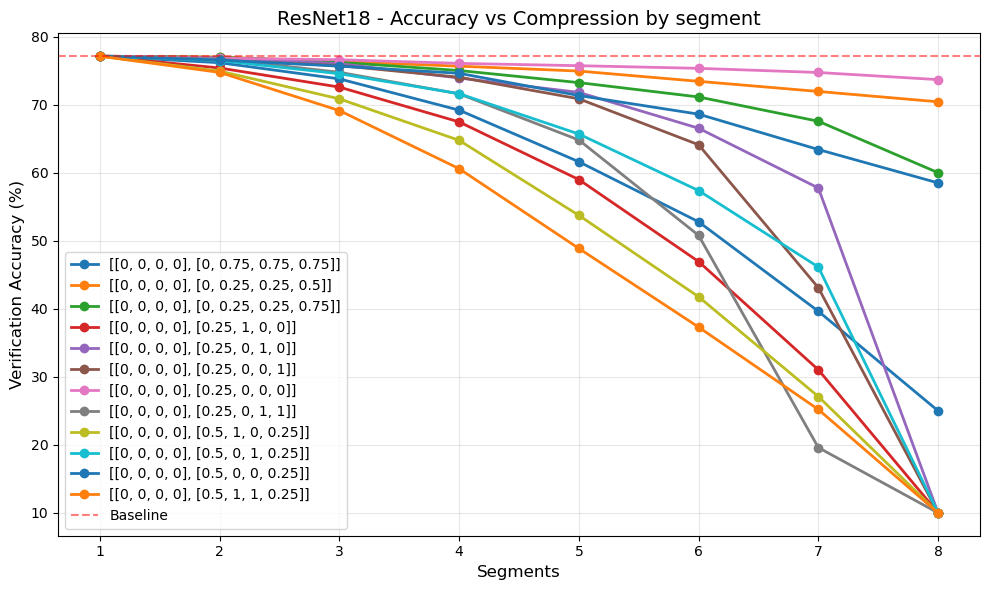

In [47]:
compressions = [
                [[0, 0, 0 ,0], [0, 0.75, 0.75, 0.75]],
                [[0, 0, 0 ,0], [0, 0.25, 0.25, 0.5]],
                [[0, 0, 0 ,0], [0, 0.25, 0.25, 0.75]],
                [[0, 0, 0 ,0], [0.25, 1, 0, 0]],
                [[0, 0, 0 ,0], [0.25, 0, 1, 0]],
                [[0, 0, 0 ,0], [0.25, 0, 0, 1]],
                [[0, 0, 0 ,0], [0.25, 0, 0 ,0]],
                [[0, 0, 0 ,0], [0.25, 0, 1, 1]],
                [[0, 0, 0 ,0], [0.5, 1, 0, 0.25]],
                [[0, 0, 0 ,0], [0.5, 0, 1, 0.25]],
                [[0, 0, 0 ,0], [0.5, 0, 0, 0.25]],
                [[0, 0, 0 ,0], [0.5, 1, 1 ,0.25]],
                ]
results = run_experiments(model, compressions, max_segments)
plot_experiment_results(checkpoint, results, model_name, max_segments)